In [1]:
import matplotlib.pyplot as plt
import numpy as np
from brian2.only import *
import seaborn as sns
import deepdish as dd
from scipy.stats import bootstrap

import plot_utils as pu
from digest import conds, get_digest_output, get_voltages
import isi_indexing as ii
from readout import load_results
from digest import get_voltage_histograms

import conf.isi5_mouse as cfg
from demonstrator import demonstrator

In [2]:
isi, templ = 500, 'R'
net, ipair, istim = [demonstrator[k] for k in ('net', 'ipair', 'istim')]
pair, stim = cfg.pairings[ipair], cfg.pairings[ipair][istim]

In [3]:
def index(n0, n1):
    return ((n0-n1)/(n0+n1))

In [4]:
def label(STD, TA):
    if STD and TA:
        return 'STD+TA'
    elif STD:
        return 'STD only'
    elif TA:
        return 'TA only'
    return 'no plasticity'

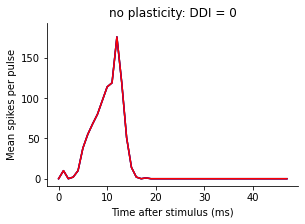

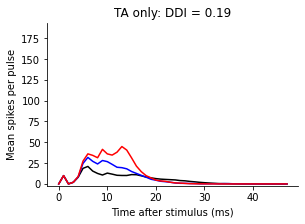

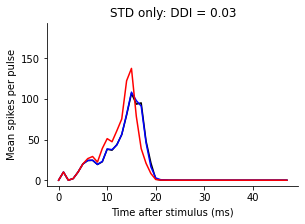

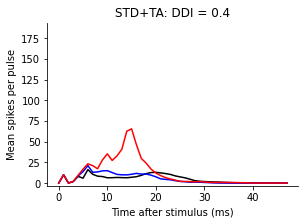

In [5]:
net, ipair, istim = [demonstrator[k] for k in ('net', 'ipair', 'istim')]
pair, stim = cfg.pairings[ipair], cfg.pairings[ipair][istim]
tmax = 0
pmax = 0
hists = []
for STD in cfg.STDs:
    for TA in cfg.TAs:
        res = load_results(
            cfg.fname.format(net=net, isi=isi, STD=STD, TA=TA, templ=templ),
            compress=True, tmax=100*ms, process_dynamics=False)
        histograms = {cond: res['spikes'][ipair][stim][cond]['spike_hist']
                      for cond in conds}
        index_N, index_t = ii.get_onset_ordering(cfg, np.stack([h for h in histograms.values()]))
        tmax = max(tmax, np.max(index_t)+1)
        hists.append(histograms)
        pmax = max(pmax, *[h.sum(0).max() for h in histograms.values()])

time = np.arange(tmax) * cfg.params['dt']
for STD in cfg.STDs:
    for TA in cfg.TAs:
        histograms = hists.pop(0)
        fig, ax = plt.subplots(figsize=(4.5,3))
        for cond, h in histograms.items():
            pspike = h.sum(0)[:tmax]
            ax.plot(time/ms, pspike, c=pu.colors[cond], label=cond)
        plt.xlabel('Time after stimulus (ms)')
        plt.ylabel('Mean spikes per pulse')
        plt.title(f'{label(STD, TA)}: DDI = {index(histograms["dev"].sum(), histograms["msc"].sum()):.2g}')
        ax.set_ylim(top=1.1*pmax)
        sns.despine()